In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [52]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname = '2-8h30m-600-spec1d.npz'

In [53]:
data = np.load(data_dir + fname) #object, flag (0, 1), wavelength. flags: 0 -> iamge, 1 -> ivar

In [54]:
def dataPrime(data):
    """Returns the ratio of data over error"""
    
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    
    return (image)*np.sqrt(ivar)

In [55]:
def Chi2Null(data):
    """Returns the null chi2 of the 2D spectra by squaring dataPrime and then summing it along column axis"""
    
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    
    return np.sum((dataPrime(image, ivar))**2, axis = 1)

In [56]:
def wave_grid(data):
    """Returns wavegrid based on header file from data"""
    
    crval1 = float(str(data['headers'][1]).split("CRVAL1")[1].split("=")[1].split("/")[0]) #Starting value
    cdelt1 = float(str(data['headers'][1]).split("CDELT1")[1].split("=")[1].split("/")[0]) #Pixel size
    
    collapsedSpectrum = data['data_ivar'][:, 0, :]
    
    wave_grid = crval1 + cdelt1 * np.arange(collapsedSpectrum[1].shape[0])
    wave_grid *= 10 #Convert wave_grid to Angstrom from nm
    return wave_grid

In [57]:
def lambda_to_z(wavelength):
    """Converts wavelength grid to redshift grid"""
    
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    
    return (wavelength/lambda0 - 1)

In [58]:
def Window(z, wg, z_grid, window_width = 0.005):
    """Returns a range of pixel in the specified window width
    
    Parameters
    ----------
    z: Centre of the window
    wg: wave grid that needs to be windowed
    z_grid: redshift grid of the wave_grid
    window_width: size of the window in redshift space
    
    Returns
    -------
    windowed_array: windowed array of the windowing_array    
    """
    windowed_array = wg[(z_grid > (z - window_width)) & (z_grid < (z + window_width))]
    
    #Find the idx of the edges of the window
    #minidx = np.where(windowing_array == np.min(windowed_array)) 
    #maxidx = np.where(windowing_array == np.max(windowed_array))
    
    #print(np.min(windowed_array)); print(np.max(windowed_array))
    #return minidx, maxidx, windowed_array
    return windowed_array

In [59]:
def Model(z, wg2, width, Amp = 1):
    """Returns Gaussian filter model at redshift z
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    wg2: pixel grid of the Window
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    model = Amp/2*(Gaussian(wg2, lambda_obs - separation_r, width) + Gaussian(wg2, lambda_obs + separation_r, width))
        
    return model

In [60]:
def SNR_calculator(maskname, data):
    """maskname[-3:] yields the grating number. z_range changes depending
    on maskname because of variation in grating. The start and end points
    are chosen by inspecting the header file of the data."""
    
    if(maskname[-3:] == '270'):
        z_range = np.arange(0.677, 1.5, 0.001)
    elif(maskname[-3:] == '600'):
        z_range = np.arange(0.7, 1.6, 0.001)
    widths = np.arange(1., 3., .5)
    
    #Read data
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    results = np.zeros((z_range.size, image.shape[0], widths.size))
    Amps = np.zeros((z_range.size, image.shape[0], widths.size))
    
    for i, z in enumerate(z_range):
        wg2 = Window(z, wg, z_grid)
        
        model = Model(z, wg2, widths)
        #print('model ' + str(model.shape))
        #Find the idx of the edges of the windows and slice the image file to multiply with modelPrime
        minidx = np.where(wg == np.min(wg2))[0][0] 
        maxidx = np.where(wg == np.max(wg2))[0][0]
        imageSliced = image[:,minidx:maxidx+1]
        
        medians = np.median(imageSliced, axis = 1)
        imageSliced = imageSliced - medians[:, np.newaxis]
        print(medians[:, np.newaxis].shape)
        print(imageSliced.shape)
        
        print('image sliced ' + str(imageSliced.shape))
        imageSliced = imageSliced[:, :, np.newaxis] #Broadcasting
        print('image sliced broadcasted ' + str(imageSliced.shape))
        ivarSliced = ivar[:,minidx:maxidx+1]
        ivarSliced = ivarSliced[:, :, np.newaxis] #Broadcasting
        imagePrimeSliced = imageSliced*np.sqrt(ivarSliced)
        print('image prime sliced ' + str(imagePrimeSliced.shape))
        Mprime = np.sqrt(ivarSliced)*model
        print('Mprime ' + str(Mprime.shape))
        Denominator = Mprime**2
        print('Denom' + str(Denominator.shape))
        Denominator = np.sum(Denominator, axis = 1)
        print('Denom' + str(Denominator.shape))
        Numerator = Mprime*imagePrimeSliced
        print('Nume' + str(Numerator.shape))
        Numerator = np.sum(Numerator, axis = 1)
        print('Nume' + str(Numerator.shape))
        """
        sigmaA^(-2) = M'.M'
        A = (D'.M')/(M'.M') => (D'.M')*(sigmaA^(2))
        """
        
        Amp = Numerator/Denominator
        sigmaA = np.sqrt(1./Denominator)
        SNR = Amp/sigmaA
        
        results[i] = SNR
        Amps[i] = Amp

    results = results.transpose([1, 2, 0]) #This maintains the indices
    Amps = Amps.transpose([1, 2, 0])
    
    return z_range, widths, results, Amps

In [61]:
from time import time

start = time()
z, widths, SNR_tmp, Amps_tmp = SNR_calculator('2-8h30m-270', data)
end = time()

tot_time = end - start
print(str(tot_time))

(143, 1)
(143, 35)
image sliced (143, 35)
image sliced broadcasted (143, 35, 1)
image prime sliced (143, 35, 1)
Mprime (143, 35, 4)
Denom(143, 35, 4)
Denom(143, 4)
Nume(143, 35, 4)
Nume(143, 4)
(143, 1)
(143, 41)
image sliced (143, 41)
image sliced broadcasted (143, 41, 1)
image prime sliced (143, 41, 1)
Mprime (143, 41, 4)
Denom(143, 41, 4)
Denom(143, 4)
Nume(143, 41, 4)
Nume(143, 4)
(143, 1)
(143, 47)
image sliced (143, 47)
image sliced broadcasted (143, 47, 1)
image prime sliced (143, 47, 1)
Mprime (143, 47, 4)
Denom(143, 47, 4)
Denom(143, 4)
Nume(143, 47, 4)
Nume(143, 4)
(143, 1)
(143, 53)
image sliced (143, 53)
image sliced broadcasted (143, 53, 1)
image prime sliced (143, 53, 1)
Mprime (143, 53, 4)
Denom(143, 53, 4)
Denom(143, 4)
Nume(143, 53, 4)
Nume(143, 4)
(143, 1)
(143, 59)
image sliced (143, 59)
image sliced broadcasted (143, 59, 1)
image prime sliced (143, 59, 1)
Mprime (143, 59, 4)
Denom(143, 59, 4)
Denom(143, 4)
Nume(143, 59, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143,

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image slice

Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60

Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image slice

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)
(143, 1)
(143, 61)
image sliced (143, 61)
image sliced broadcasted (143, 61, 1)
image prime sliced (143, 61, 1)
Mprime (143, 61, 4)
Denom(143, 61, 4)
Denom(143, 4)
Nume(143, 61, 4)
Nume(143, 4)


(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)


image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1

(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image sliced (143, 60)
image sliced broadcasted (143, 60, 1)
image prime sliced (143, 60, 1)
Mprime (143, 60, 4)
Denom(143, 60, 4)
Denom(143, 4)
Nume(143, 60, 4)
Nume(143, 4)
(143, 1)
(143, 60)
image slice

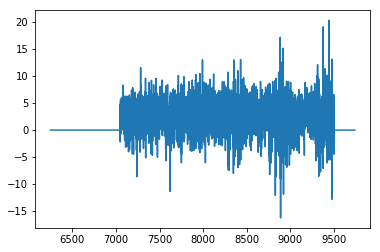

In [62]:
idx = 6
dataprimed = dataPrime(data) 
plt.plot(wave_grid(data), dataprimed[idx])
#plt.plot(wave_grid(data), image[6])

### 45000 models over 143 galaxies ~ 8.10 seconds

### -------

## Find the highest SNR models

In this section, we write a function that extracts the highest SNR models that crosses the threshold of SNR = 7 for a given galaxy and generates PDFs for us to visually inspect. We heuristically pick the number 10 to test this.

In [63]:
print(SNR_tmp.shape)
print(Amps_tmp.shape)

(143, 4, 823)
(143, 4, 823)


### 1D spectra and error

In [64]:
#Delete the spec1d.npz substring
string2 = '-spec1d.npz'
maskname = fname[:len(string2)]

Text(0.5,1,'1D inverse variance')

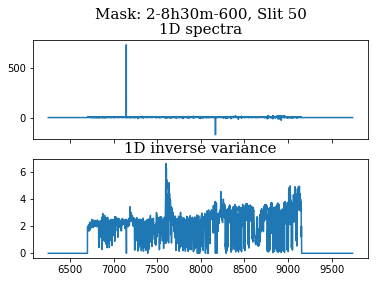

In [65]:
idx = 50

image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

imagetmp = image[idx, :]
ivartmp = ivar[idx, :]

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data), imagetmp)
axarr[0].set_title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
#plt.savefig('results/spectra1d/' + maskname + '-' + str(idx) + '-spectra1d.pdf', dpi = 600, bbox_inches = None)

(4, 823)


Text(0.5,1,'Mask: 2-8h30m-600, Slit 50')

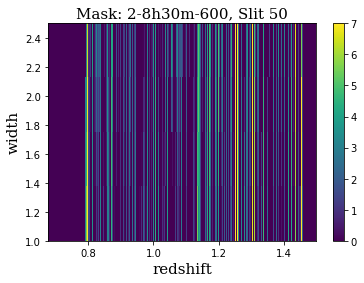

In [66]:
print(SNR_tmp[idx].shape)
plt.imshow(SNR_tmp[idx], aspect='auto', interpolation='None', \
           extent=[np.min(z), np.max(z), np.min(widths), np.max(widths)], vmin=0, vmax=7)
plt.colorbar()
plt.ylabel('width', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx),  fontsize = 15, fontname = 'serif')
#plt.savefig("results/SNR2D/" + maskname + '-' + str(idx) + "-SNR2d.pdf", dpi = 600, bbox_inches = None)

In [67]:
print("Max SNR for slit " + str(idx) + " is " + str(np.nanmax(SNR_tmp[idx])))

"""nanargmax flattens SNR_tmp[idx] and finds the index number of the max value while ignorning NaNs.
Then passing that index to unravel_index helps find the coordinate location of the max in the original
matrix shape. The second argument is the shape of the matrix. Thus for a given index and a given matrix
shape, unravel_index can unflatten the 1D data and reshape it to the desired matrix shape and then 
find out the coordinate of the desired value."""

w, redshift = np.unravel_index(np.nanargmax(SNR_tmp[idx]), np.array(SNR_tmp[idx]).shape)
print("Maximum SNR has -- width: " + str(widths[w]) + ' and redshift: ' + str(z[redshift]))


#Corresponding wavelength
lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
print("Wavelength corresponds to: " + str(lambda0*(1+z[redshift])))
print(lambda0)

Max SNR for slit 50 is 16.17712935166812
Maximum SNR has -- width: 2.5 and redshift: 1.2520000000000007
Wavelength corresponds to: 8396.544842000003
3728.4835000000003


Text(0.5,1,'Mask: 2-8h30m-600, Slit 50\nz = 1.252, w = 2.5')

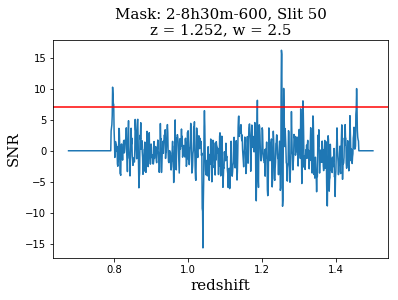

In [68]:
plt.plot(z, SNR_tmp[idx, w])
plt.axhline(7, c = 'red')
plt.ylabel('SNR', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) +"\n" +\
          "z = " + str(np.round(z[redshift], 3)) + ', w = ' + str(np.round(widths[w],2)) \
          , fontsize = 15, fontname = 'serif')
#plt.xlim([z[redshift] - .1, z[redshift] + .1])
#plt.savefig("results/SNRvsRedshift/" + maskname + '-' + str(idx) + "-SNR_vs_z.pdf", dpi = 600, bbox_inches = None)

### Zooming into 1D spectra around wavelength range with the peak

In [69]:
lambda0*(1+z[redshift])-.1

8396.444842000003

In [70]:
z[redshift]

1.2520000000000007

In [71]:
Amps_tmp[idx, w, redshift]

49.600592569222044

In [72]:
wg1 = wave_grid(data)
z_grid = lambda_to_z(wg1)
wg3 = wg1[(wg1 > (1+z[redshift])*(3728.4835-20.)) & (wg1 < (1+z[redshift])*(3728.4835+20.))]

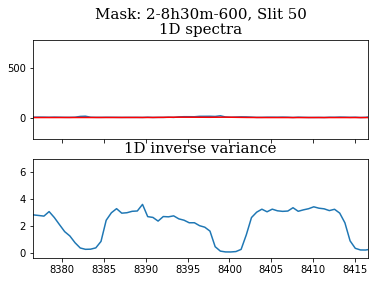

In [73]:
ranges = 20

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data), imagetmp)
axarr[0].set_title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
axarr[0].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])
axarr[1].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])

axarr[0].plot(wg3, Model(z[redshift], wg3, widths[w], Amp=Amps_tmp[idx, w, redshift]), c = 'red')

#plt.savefig("results/PeakZoom/" + maskname + '-' + str(idx) + "-zoom1d.pdf", dpi = 600, bbox_inches = None)

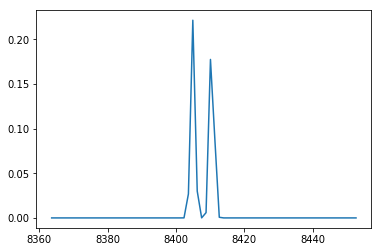

In [23]:
#wg2 = wave_grid(data)[(wave_grid(data) > (3727.092 - 20.)) & (wave_grid(data) < (3727.092 + 20.))]
plt.plot(wg3, Model(z[redshift], wg3, widths[w]))

### Checking raw signal-to-noise

In [ ]:
image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

In [ ]:
rawsnr = image*np.sqrt(ivar)
np.where(rawsnr == np.max(rawsnr))

Need: For every row, i.e. ngal, check if SNR > 7. If yes, then find max 10 SNR z and w for that gal and generate PDF. If not, ignore

In [ ]:
tmp = np.partition(SNR_tmp, 10, axis = 0)
tmp = tmp[:,-10:]
tmp.shape

In [ ]:
SNR_tmp.shape

In [ ]:
a = np.array([[ 6,  4,  10,  2,  2],
               [10,  9,  8,  7,  6]])

In [ ]:
a.shape

In [ ]:
b = np.partition(a, 4)    # top 3 values from each row

In [ ]:
b

In [ ]:
b[:,-3:]

## Test with synthetic signal

In [ ]:
synthSpectra = np.arange(7800, 7880, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model(1.1, synthSpectra, .2)
errstd = 0.1
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData[:, np.newaxis]

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData, c = 'red')
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

In [121]:
A = np.arange(1, 10, .1)
B = np.arange(10, 19, .1)

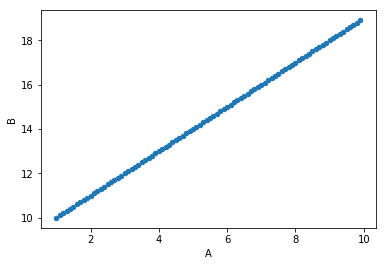

In [128]:
import pandas as pd
df = pd.DataFrame({'A':A, 'B':B})
df.plot('A', 'B', kind='scatter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027731386320>,
      dtype=object)

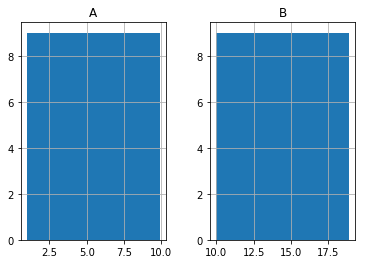

In [132]:
df.hist()

In [135]:
SNR_tmp[idx, w, redshift]

27.303268222017525